In [1]:

#TODO: Super upgraded walk forward optimization
#TODO: Data imputation


In [30]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from utils import apply_clipped_optimizer
pd.set_option("display.max_columns", 200)
from sklearn.metrics import r2_score

df = pd.read_csv('ListingsAndSales.csv')
#not sold flag
df['NotSoldFlag'] = 0
df.loc[df['SalesDate'].isnull(), 'NotSoldFlag'] = 1

print('percent not yet sold:', df['NotSoldFlag'].mean())

df.ListingDate = pd.to_datetime(df.ListingDate)

df.SalesDate = pd.to_datetime(df.SalesDate)
df.SalesDate = df.SalesDate.fillna(df.SalesDate.max())

#Get day of dataset for each sample
df['ListingDay'] = (df.ListingDate - df.ListingDate.min()).dt.days
df = df.sort_values('ListingDay')

#calculate days it took to sell the listing if it's sold
df['DaysSold'] = (df.SalesDate - df.ListingDate).dt.days.astype(float) + 1

#loop through the variables and replace missing values with avg and create dummy variables
col_dates = ['ListingDate', 'SalesDate']
for col in df.columns:
    if not col in col_dates:
        if df[col].isnull().sum(axis=0) > 0:
            df[col + "_mv"] = (df[col].isnull())
            col_avg = df.loc[df[col].isnull() == False, col].mean()
            df[col] = df[col].fillna(col_avg)

#Columns to use as regressor
X = df.drop(['DaysSold', 'ListingDate', 'SalesDate', 'NotSoldFlag'], axis=1)

#Column to use as target
Y = df[['DaysSold']].as_matrix().astype(np.float32)

scaler = StandardScaler()
X = pd.DataFrame(
    scaler.fit_transform(X), columns=X.columns).as_matrix().astype(np.float32)
sold = df['NotSoldFlag'].as_matrix().astype(np.float32)

#For numeric stability
EPSILON = 1e-10

class Model():
    def __init__(self, input_size, layer_sizes):
        self.input_size = input_size
        self.layer_sizes = layer_sizes

        self.sold = tf.placeholder(tf.float32, shape=(None))
        self.x = tf.placeholder(tf.float32, shape=(None, input_size))
        self.y = tf.placeholder(tf.float32, shape=(None))

        self.layers = [self.x]
        for layer_size in layer_sizes:
            next_layer = tf.nn.leaky_relu(
                tf.layers.dense(self.layers[-1], layer_size))
            self.layers.append(next_layer)

        self.output = tf.nn.softplus(tf.layers.dense(self.layers[-1], 1))

        self.loss_indicator = (tf.cast(self.output < self.y, tf.float32) *
                               (1 - self.sold) + self.sold)
        loss_numerator = tf.reduce_sum(
            tf.square(self.y - self.output) * self.loss_indicator)
        loss_denominator = (tf.reduce_sum(self.loss_indicator)) + EPSILON
        self.loss = loss_numerator / loss_denominator

        opt_fcn = tf.train.AdamOptimizer()
        self.optimizer = apply_clipped_optimizer(opt_fcn, self.loss)

    def train(self, X, Y, sold, epochs):
        sess = tf.Session(config=tf.ConfigProto(device_count={'GPU': 0}))
        sess.run(tf.global_variables_initializer())
        n_samples = X.shape[0]
        trn_samples = (n_samples * 4) // 5
        samples = np.arange(n_samples)
        trn_s = np.random.choice(samples, size=trn_samples, replace=False)
        val_samples = [s for s in samples if s not in trn_s]
        X_train, X_test = X[trn_s], X[val_samples]
        Y_train, Y_test = Y[trn_s], Y[val_samples]
        sold_train, sold_test = sold[trn_s], sold[val_samples]
        self.trn_losses = []
        self.val_losses = []
        self.r2_scores = []
        bs = 64
        num_batches = (trn_samples // bs) + 1
        for epoch in range(epochs):
            trn_loss = []
            order = np.arange(trn_samples)
            np.random.shuffle(order)
            for itr in range(trn_samples // bs):
                rows = order[itr * bs:(itr + 1) * bs]
                if itr + 1 == num_batches:
                    rows = order[itr * bs:]
                X_active, Y_active, Sold_active = X_train[rows, :], Y_train[
                    rows], sold_train[rows]
                feed_dict = {
                    self.x: X_active,
                    self.y: Y_active,
                    self.sold: Sold_active
                }
                _, loss, yhat = sess.run(
                    [self.optimizer, self.loss, self.output], feed_dict)
                trn_loss.append(loss)
            if epoch % 2 == 0:
                trn_loss_mean = np.mean(trn_loss)
                self.trn_losses.append(trn_loss_mean)
                feed_dict = {
                    self.x: X_test,
                    self.y: Y_test,
                    self.sold: sold_test
                }
                val_loss, yhat = sess.run([self.loss, self.output], feed_dict)
                self.val_losses.append(val_loss)
                self.r2_scores.append(r2_score(Y_test, yhat))
            if epoch % 10 == 0:
                print('epoch:', epoch, 'train loss: ', trn_loss_mean,
                      'val loss: ', val_loss, 'r2_score:', self.r2_scores[-1])
        y_tst_predict = sess.run(self.output, {self.x: X_test})

    def visualize(self, name):
        plt.plot(self.trn_losses, label='train loss')
        plt.plot(self.val_losses, label='test loss')
        plt.title('least square losses')
        plt.legend()
        plt.savefig(name + 'losses.jpg')
        plt.show()
        plt.plot(self.r2_scores, label='validation r2_scores')
        plt.legend()
        plt.title('r2 scores')
        plt.savefig(name + 'r2scores.jpg')
        plt.show()


n_features = X.shape[1]


percent not yet sold: 0.6864035087719298


epoch: 0 train loss:  713.96625 val loss:  762.83923 r2_score: -0.07843433945684919
epoch: 10 train loss:  647.939 val loss:  684.0804 r2_score: 0.024221029719644127
epoch: 20 train loss:  577.73535 val loss:  601.9753 r2_score: 0.13207913407518213
epoch: 30 train loss:  516.0049 val loss:  529.2449 r2_score: 0.22732779577645268
epoch: 40 train loss:  461.88687 val loss:  467.06042 r2_score: 0.30944820208909884
epoch: 50 train loss:  418.68283 val loss:  414.59714 r2_score: 0.3787047102210903
epoch: 60 train loss:  381.37863 val loss:  373.47906 r2_score: 0.4358723248022739
epoch: 70 train loss:  353.29767 val loss:  341.59534 r2_score: 0.4820193381902439
epoch: 80 train loss:  329.00406 val loss:  316.49686 r2_score: 0.5181990244197254
epoch: 90 train loss:  312.35196 val loss:  296.8713 r2_score: 0.5460432958916275


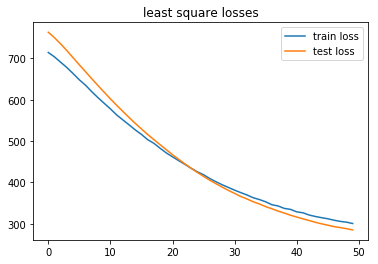

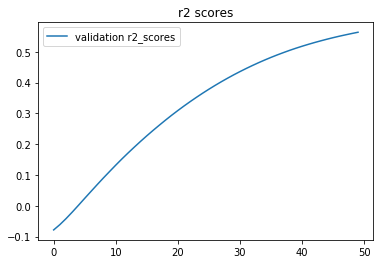

In [31]:

model = Model(n_features, layer_sizes=[])
model.train(X, Y, sold, epochs=100)
model.visualize('linear_regression')


epoch: 0 train loss:  696.02124 val loss:  671.58923 r2_score: 0.03216551165343662
epoch: 10 train loss:  212.0546 val loss:  227.39252 r2_score: 0.6310508378283355
epoch: 20 train loss:  186.06618 val loss:  205.70277 r2_score: 0.6595058501304872
epoch: 30 train loss:  176.3085 val loss:  198.09003 r2_score: 0.6679805559641051
epoch: 40 train loss:  175.92245 val loss:  197.9591 r2_score: 0.6690834016739163
epoch: 50 train loss:  174.66371 val loss:  196.52863 r2_score: 0.671110862376729
epoch: 60 train loss:  172.28748 val loss:  197.27052 r2_score: 0.6723613726936905
epoch: 70 train loss:  172.11559 val loss:  196.88947 r2_score: 0.6731269303269184
epoch: 80 train loss:  171.42047 val loss:  194.97508 r2_score: 0.674685349697759
epoch: 90 train loss:  171.02449 val loss:  194.98827 r2_score: 0.6755734997419651


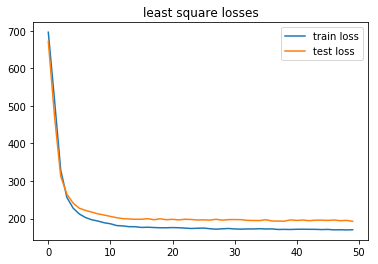

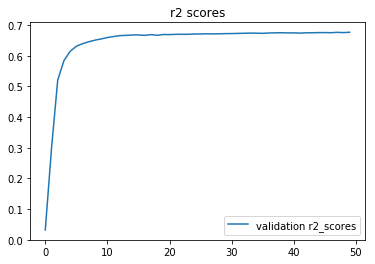

In [32]:

model = Model(n_features, layer_sizes=[64])
model.train(X, Y, sold, epochs=100)
model.visualize('one_hidden_layer')


epoch: 0 train loss:  652.2876 val loss:  534.31854 r2_score: 0.20379200835636202
epoch: 10 train loss:  182.93051 val loss:  178.50275 r2_score: 0.6966744280435151
epoch: 20 train loss:  178.94644 val loss:  171.88855 r2_score: 0.7026738226124543
epoch: 30 train loss:  177.15112 val loss:  171.2853 r2_score: 0.7064427963298837
epoch: 40 train loss:  174.58696 val loss:  171.49734 r2_score: 0.7068542437194039
epoch: 50 train loss:  173.72606 val loss:  169.666 r2_score: 0.7101320358533922
epoch: 60 train loss:  173.08247 val loss:  169.93639 r2_score: 0.7082665343390506
epoch: 70 train loss:  173.70372 val loss:  169.14413 r2_score: 0.7113308190343783
epoch: 80 train loss:  172.27527 val loss:  169.82559 r2_score: 0.7123174502717348
epoch: 90 train loss:  171.214 val loss:  165.80345 r2_score: 0.7141120460428232


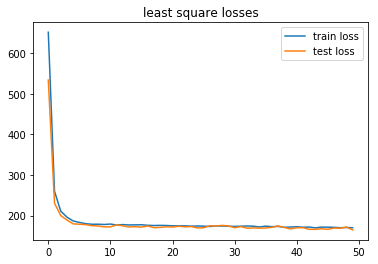

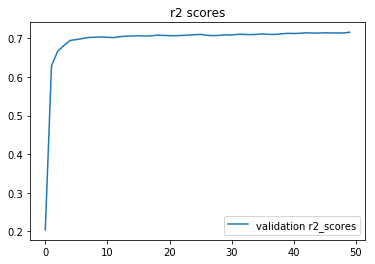

In [33]:

model = Model(n_features, layer_sizes=[64, 64])
model.train(X, Y, sold, epochs=100)
model.visualize('one_hidden_layer')
